# **Import libraries**

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import matplotlib.image as mpimg
import pandas as pd
import wandb
import random
import numpy as np
from wandb.keras import WandbCallback
import glob as gb
import cv2
import keras
import pathlib

# **Load dataset**

In [7]:
code = {'Cat':0 ,'Dog':1 }

In [8]:
data_dir = pathlib.Path('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages')

In [9]:
pet_images_dict = {
    'cats': list(data_dir.glob('Cat/*')),
    'dogs': list(data_dir.glob('Dog/*')),
}

pet_labels_dict = {
    'cats': 0,
    'dogs': 1,
}

In [10]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
X, Y = [], []

for pet_name, images in pet_images_dict.items():
    print(pet_name)
    for image in images:
        img = cv2.imread(str(image))
        if isinstance(img,type(None)): 
            #print('image not found')
            continue
            
        elif ((img.shape[0] >= IMAGE_HEIGHT) and  (img.shape[1] >=IMAGE_WIDTH)):
            resized_img = cv2.resize(img,(IMAGE_WIDTH,IMAGE_HEIGHT))
            X.append(resized_img)
            Y.append(pet_labels_dict[pet_name])
        else:
            #print("Invalid Image")
            continue

print(f'we have {len(X)} items in X ')

cats


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


dogs


Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


we have 22039 items in X 


In [11]:
Y = np.array(Y).reshape(-1, 1)

from sklearn.preprocessing import OneHotEncoder
one=OneHotEncoder()
y=Y=one.fit_transform(Y).toarray()
X = np.array(X)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,  shuffle=True, random_state=42)

# **Build model**

In [15]:
# https://keras.io/api/applications/
base_model = tf.keras.applications.EfficientNetB2(input_shape=(224, 224, 3), weights = 'imagenet',include_top=False)
base_model.trainable = False

In [16]:
inputs = base_model.input

x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

#model.summary()

In [17]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [18]:
X_train.shape

(8815, 224, 224, 3)

In [19]:
y_train.shape

(8815, 2)

In [20]:
history = model.fit(X_train, y_train, batch_size=32,epochs=5)

Epoch 1/5


2023-03-30 22:52:42.271044: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


276/276 [==============================] - 29s 55ms/step - loss: 0.3330 - accuracy: 0.9789
Epoch 2/5
276/276 [==============================] - 15s 55ms/step - loss: 0.0705 - accuracy: 0.9925
Epoch 3/5
276/276 [==============================] - 15s 55ms/step - loss: 0.0120 - accuracy: 0.9960
Epoch 4/5
276/276 [==============================] - 15s 55ms/step - loss: 0.0139 - accuracy: 0.9967
Epoch 5/5
276/276 [==============================] - 15s 55ms/step - loss: 0.0133 - accuracy: 0.9971


In [21]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
69/69 [==============================] - 6s 58ms/step - loss: 0.0548 - accuracy: 0.9905
test loss, test acc: [0.054837048053741455, 0.9904718399047852]


# **Evaluation**

In [22]:
y_pred = model.predict(X_test)

69/69 [==============================] - 6s 51ms/step


In [25]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1) ) )

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1085
           1       0.99      0.99      0.99      1119

    accuracy                           0.99      2204
   macro avg       0.99      0.99      0.99      2204
weighted avg       0.99      0.99      0.99      2204



# **LIME**

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
img_size = (224, 224)
preprocess_input = keras.applications.efficientnet.preprocess_input
last_conv_layer_name = "top_conv"

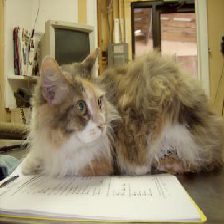

In [195]:
image_raw = keras.preprocessing.image.load_img(img_path2, target_size=(224,224))
image_raw

In [196]:
image = keras.preprocessing.image.img_to_array(image_raw)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
image[0].shape

(224, 224, 3)

In [197]:
predictions = model.predict(image)

1/1 [==============================] - 0s 32ms/step


In [198]:
# extract the index of the top 5 classes predicted by the model for the image selected 

model.predict(image).argsort()[0, -5:][::-1]

#keep the index of the first and the second class 
first_class = model.predict(image).argsort()[0, -5:][-1]
second_class = model.predict(image).argsort()[0, -5:][-2]

1/1 [==============================] - 0s 28ms/step


In [199]:
from lime.lime_image import LimeImageExplainer
explainer = LimeImageExplainer()

In [200]:
explanation = explainer.explain_instance(image[0], #the image
                                         model.predict, 
                                         top_labels=2, #want just to see the 2 main classes predicted
                                         num_samples=500, # number of observation sampled from the original distribution in order to computer the linear regression
                                         random_seed=42)

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


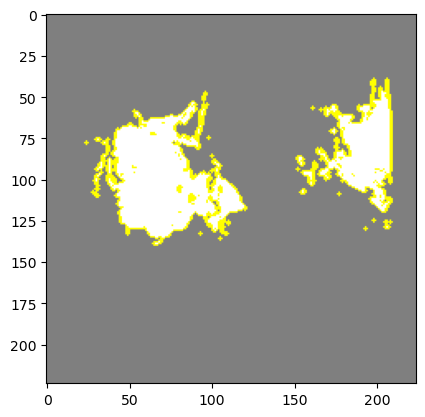

In [201]:
from skimage.segmentation import mark_boundaries
from matplotlib import pyplot as plt

# maps for the first class predicted
temp, mask = explanation.get_image_and_mask(first_class, positive_only=True, num_features=5, hide_rest=True)
# plot image and mask together
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))